In [2]:
%run training_functions.ipynb

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-11 16:54:18.160271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744390458.175020 3994194 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744390458.179503 3994194 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744390458.192190 3994194 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
['train', 'validation', 'test']
['train', 'validation', 'test']
In, Out, get_ipython, exit, quit, open, accelerate, datasets, evaluate, math, np, peft, pickle, pytest, ipytest, pd, transformers, torch, load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names, LoftQConfig, LoraConfig, get_peft_model, AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, Trainer, SFTTrainer, SFTConfig, @py_builtins, @pytest_ar, model_from_pkl, ds_builder1, ds_builder2, ds_builder3, ds_gs, ds_gst1_train, ds_gst1_test, ds_gst2_train, ds_gst2_test, search_with_strings, map_data, print_trainable_parameters, metric, comp_metrics_output, compute_metrics, make_trainer, get_dataframe, get_training_output, 

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [3]:
print(ds_gst1_train[0]['record'])

NZ_LIXJ01000001.1


In [4]:
print(ds_gst1_train[0]['text'][:1000])

CGACTCCGCACAGGCCCTAGGCGTGGTCCACGCATCGAGCGCGTGCGCCGTGGCATACACCCGGGCCACCCGTACGACCCTTCCGGCCGCCCCGTGTGCGCCCTCGTCGCCGAGTCCGCTCCGGCGCGCGCGGGCGCACTGCTGTTCCGCGCGGTGTCATGCGCTCCTCCCGTCCCGACATGCGCCTTTTTGCAGGGGAGAGGGAGGGGTAGGGTCGCGCGTACGCCTAGCACGGGGGAACGGTCTTGGGGGACGCAGTGGACGTACGGGTGGCGGCGATCGCCAGTCTCACACCGCTCGAAGAACTCGACAGCGATCCGTTCCTCGTGGACACCCGCAGCCAGCACGACATGTGCGCACGCTGGGCCGCGGACAAGGGGTACGTCGTCACCCGCCAGCTCCGCTTCTACGGGCTGCGCCCCGATCACCACGCCCTGTGGAGCGATGTCGAGAGCGGCGACGTCGAGGTGTTCGTCGCCGCCAACGACCGGGTGCTGGAACGGGCCCTCACGTCGGTCGCGGAGTTCGCCGCGGAGTGCGCGCGGCGCGGCGTGCGTCTGGAGATCGCCGGGCTGGACGAGCCGCCGTACAACGCCGGCACGAAGGCGAGCGTGCATCGCAGGCTCTCCATGCCCACCGCCGGTTACGACGGCCGCTGACGCACTCCGCCTCCACTGCCGGCTCGCGGCCCCTGCCCTCGTCCCGGCCCCGTCCCTTCCGCGGCTTGCCGTCGGGCTGTGACAGGCTGGGGGACAGGGTCCGCAGCGGCGGGGCCCGGACGTGAGGTGGTTGAGGCGTGGGTGACGGGCGATGGCGAACGGTCGGCAACGCCCTGATGCGAGTGGCCGTGGTGTGGGCGGTCTCCACGCTCACGATGCTGGTGCTCGCCGGGGTGCTGCCGGAGTTCCGGCTCCAGTCGGACGACGGCGACAGCATCACCAAGACCGCGTTCACCGCGGCCTGGGGCGCCGGAGCGTTCGGCCTGCTCTCCGCACTCGTC

In [3]:
mistral, mistral_tokenizer=model_from_pkl("Mistral-7B-Instruct-v0.1")

In [4]:
m_tokenized_genome_samples=map_data(ds_gs, mistral, mistral_tokenizer)

In [5]:
m_tokenized_stage1_train=map_data(ds_gst1_train, mistral, mistral_tokenizer)
m_tokenized_stage1_test=map_data(ds_gst1_test, mistral, mistral_tokenizer)

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 559.96 examples/s]


In [6]:
m_tokenized_stage2_train=map_data(ds_gst2_train, mistral, mistral_tokenizer)
m_tokenized_stage2_test=map_data(ds_gst2_test, mistral, mistral_tokenizer)

In [7]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [8]:
mis_lora_model=get_peft_model(mistral, config)
print_trainable_parameters(mis_lora_model)

trainable params: 3407872 || all params: 7245139968 || trainable%: 0.05


In [11]:
m_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps", 
                                    logging_steps=6, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

# Using the SFTConfig default values provides us with...
# num_train_epochs = 3.0
# eval_strategy: typing.Union[transformers.trainer_utils.IntervalStrategy, str] = 'no'
# per_device_train_batch_size = 8
# learning_rate = 2e-5
# gradient_checkpointing=False

Truncating train dataset: 100%|█| 1000/1000 [00:00<00:00, 7566.89 ex
Truncating eval dataset: 100%|█| 100/100 [00:00<00:00, 6025.26 examp


In [12]:
m_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.655200,2.586025,0.029463
12,0.644000,2.538775,0.026875
18,0.632700,2.507639,0.024180
24,0.626200,2.488919,0.019268
30,0.624500,2.477622,0.018350
36,0.620100,2.470576,0.018984
42,0.617700,2.465842,0.011035
48,0.621100,2.462125,0.009307
54,0.619500,2.459109,0.011162
60,0.619200,2.456057,0.012217


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=96, training_loss=0.6234530384341875, metrics={'train_runtime': 3236.8168, 'train_samples_per_second': 0.927, 'train_steps_per_second': 0.03, 'total_flos': 1.31126500786176e+17, 'train_loss': 0.6234530384341875})

,loss,eval_loss,eval_accuracy
steps,,,
6,0.6552,2.586025,0.029463
12,0.6440,2.538775,0.026875
18,0.6327,2.507639,0.024180
24,0.6262,2.488919,0.019268
30,0.6245,2.477622,0.018350
36,0.6201,2.470576,0.018984
42,0.6177,2.465842,0.011035
48,0.6211,2.462125,0.009307
54,0.6195,2.459109,0.011162


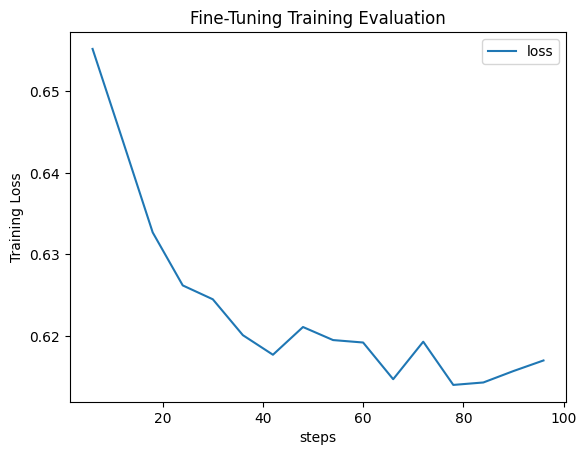

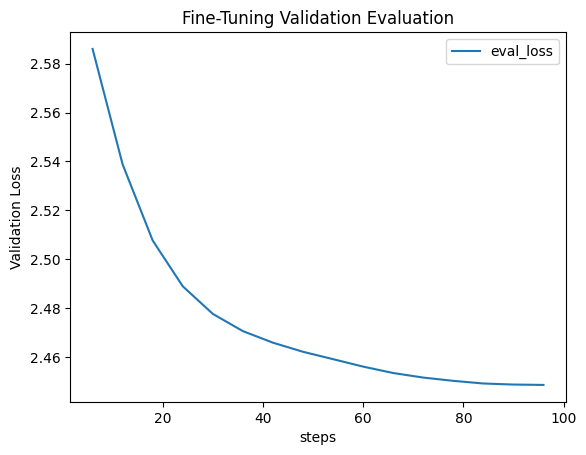

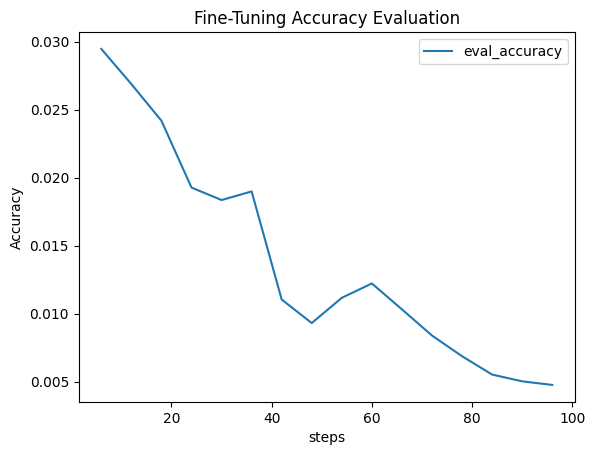

In [13]:
output=get_training_output(m_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [9]:
m2_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps", 
                                    logging_steps=2, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

Truncating eval dataset: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1435.86 examples/s]


In [11]:
m2_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.604000,2.432193,0.002832
2,0.604600,2.427761,0.015938
3,0.610200,2.426062,0.010244


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=96, training_loss=0.609934667746226, metrics={'train_runtime': 741.5993, 'train_samples_per_second': 4.045, 'train_steps_per_second': 0.129, 'total_flos': 1.31126500786176e+17, 'train_loss': 0.609934667746226})

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6042,2.432395,0.002881
2.0,0.6048,2.428582,0.010410
3.0,0.6105,2.426831,0.005352


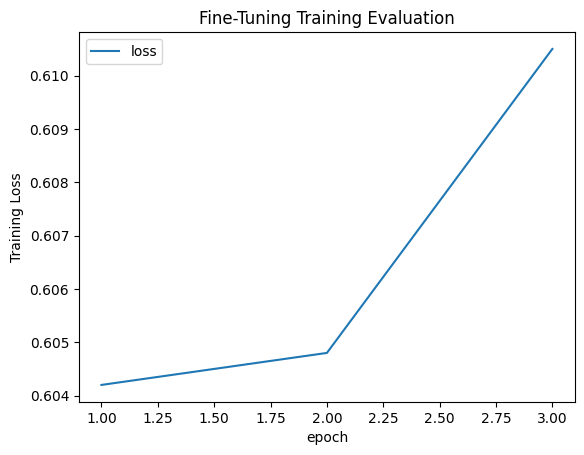

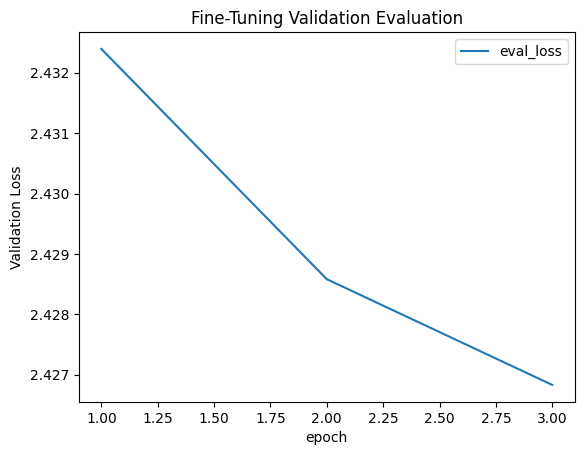

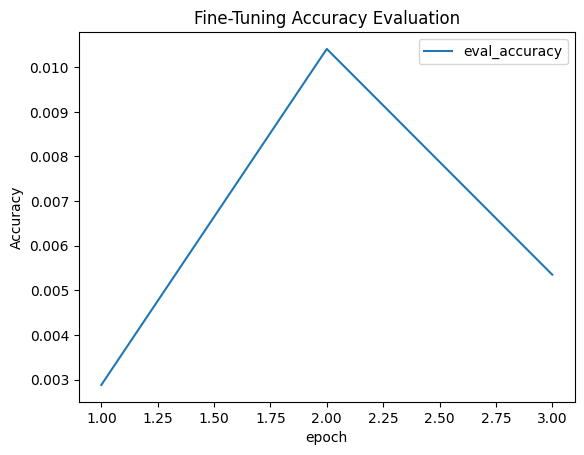

In [16]:
output=get_training_output(m2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [17]:
m_trainer.model.save_pretrained('./fine_tuned/mis/')
m2_trainer.model.save_pretrained('./fine_tuned/mis2/')

In [18]:
m_trainer.processing_class.save_pretrained('./fine_tuned/mis_token/')

('./fine_tuned/mis_token/tokenizer_config.json',
 './fine_tuned/mis_token/special_tokens_map.json',
 './fine_tuned/mis_token/tokenizer.model',
 './fine_tuned/mis_token/added_tokens.json',
 './fine_tuned/mis_token/tokenizer.json')

In [19]:
m2_trainer.processing_class.save_pretrained('./fine_tuned/mis2_token/')

('./fine_tuned/mis2_token/tokenizer_config.json',
 './fine_tuned/mis2_token/special_tokens_map.json',
 './fine_tuned/mis2_token/tokenizer.model',
 './fine_tuned/mis2_token/added_tokens.json',
 './fine_tuned/mis2_token/tokenizer.json')